In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
os.environ["SDL_VIDEODRIVER"] = "dummy" # for pygame rendering
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
import reacher
import seaborn as sns
import sys
from pathlib import Path
from agent import Agent, Policy
from common import helper as h

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/u/51/nguyenb5/unix/Reinforcement-Learning/venv/lib/python3.10/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [6]:
env_name = "Reacher-v1" 

resolution = 101  # Resolution of the policy/reward image

In [27]:
# Load policy from default path to plot
#policy_dir = Path().cwd()/'results'/'model'/f'{env_name}_params.pt'
policy_dir = f"{Path().cwd()}/results/model/Task3_reach_goal_1000_eps_params.pt"

In [28]:
sns.set()

# Create a gym environment
env = gym.make(env_name)

action_space_dim = h.get_space_dim(env.action_space)
observation_space_dim = h.get_space_dim(env.observation_space)
policy = Policy(observation_space_dim, action_space_dim)

if policy_dir:
    policy.load_state_dict(torch.load(policy_dir))
    print("Loading policy from", policy_dir)
else:
    print("Plotting a random policy")


Loading policy from /m/home/home5/51/nguyenb5/unix/Reinforcement-Learning/ex1/results/model/Task3_reach_goal_1000_eps_params.pt


In [29]:
# Create a grid and initialize arrays to store rewards and actions
npoints = resolution
state_range = np.linspace(-np.pi, np.pi, npoints)
rewards = np.zeros((npoints, npoints))
actions = np.zeros((npoints, npoints), dtype=np.int32)

# Loop through state[0] and state[1]
for i,th1 in enumerate(state_range):
    for j,th2 in enumerate(state_range):
        # Create the state vector from th1, th2
        state = np.array([th1, th2])

        # Query the policy and find the most probable action
        with torch.no_grad():
            action_dist, _ = policy(torch.from_numpy(state).float().unsqueeze(0))
        action_probs = action_dist.probs.numpy()

        # TODO: Task 4: 1. What's the best action, according to the policy?
        # .             2. Compute the reward given state
        ########## Your code starts here ##########
        # Use the action probabilities in the action_probs vector
        # (it's a numpy array)
        actions[i,j] = action_probs.argmax()
        rewards[i,j] = env.get_reward(None, None, state)
        ########## Your code ends here ##########


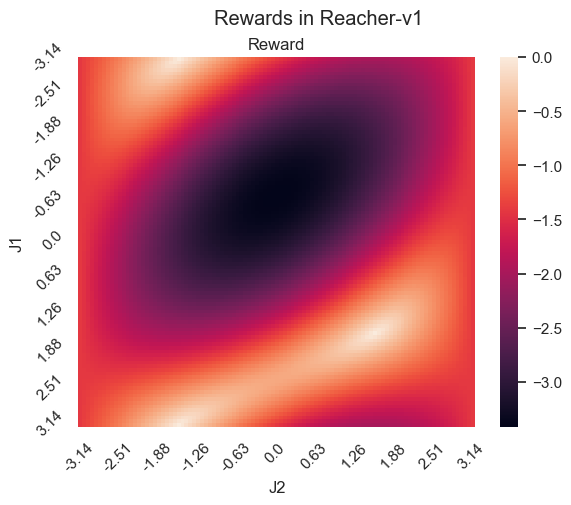

In [30]:
# Create the reward plot
num_ticks = 10
tick_skip = max(1, npoints // num_ticks)
tick_shift = 2*np.pi/npoints/2
tick_points = np.arange(npoints)[::tick_skip] + tick_shift
tick_labels = state_range.round(2)[::tick_skip]

sns.heatmap(rewards)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Reward")
plt.suptitle("Rewards in %s" % env_name)
plt.show()


In [35]:
# Find highest and lowest reward state
# min and max are reversed because the reward is negative
max_idx = np.unravel_index(np.argmin(rewards), rewards.shape)
min_idx = np.unravel_index(np.argmax(rewards), rewards.shape)

max_state = np.array([state_range[max_idx[0]], state_range[max_idx[1]]])
min_state = np.array([state_range[min_idx[0]], state_range[min_idx[1]]])

print("Highest reward state: [J1, J2] = ", max_state)
print("Lowest reward state: [J1, J2] = ", min_state)

Highest reward state: [J1, J2] =  [-8.1681409e-01  4.4408921e-16]
Lowest reward state: [J1, J2] =  [-3.14159265 -1.57079633]


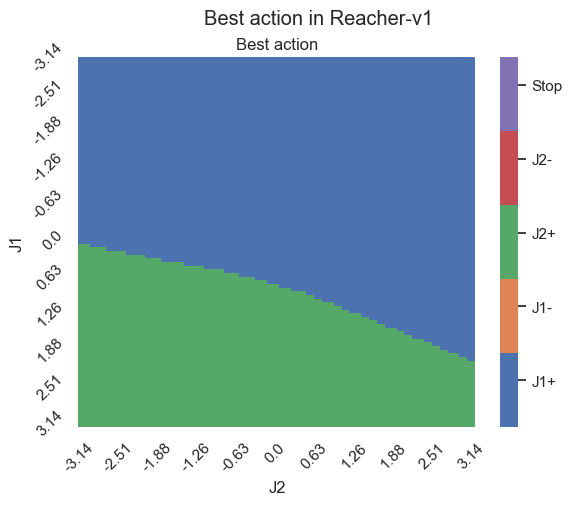

In [31]:
# # Create the policy plot
cmap = sns.color_palette("deep", action_space_dim)
sns.heatmap(actions, cmap=cmap, vmin=0, vmax=action_space_dim-1)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
colorbar = plt.gca().collections[0].colorbar
ticks = np.array(range(action_space_dim))*((action_space_dim-1)/action_space_dim)+0.5
colorbar.set_ticks(ticks)
if env.spec.id == "Reacher-v1":
    # In Reacher, we can replace 0..4 with more readable labels
    labels = ["J1+", "J1-", "J2+", "J2-", "Stop"]
else:
    labels = list(map(str, range(action_space_dim)))
colorbar.set_ticklabels(labels)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Best action")
plt.suptitle("Best action in %s" % env_name)
plt.show()